In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *
from NEID_solar_functions import *
from functions import *
#----------------------------------
# Read data
#----------------------------------



In [2]:
RV_FT_k     = np.loadtxt('../lib/FIESTA_daily_output/RV_FT_k.txt')
eRV_FT_k    = np.loadtxt('../lib/FIESTA_daily_output/eRV_FT_k.txt')
ΔRV_k       = np.loadtxt('../lib/FIESTA_daily_output/ΔRV_k.txt')
bjd_daily   = np.loadtxt('../lib/FIESTA_daily_output/bjd_daily.txt')
rv_daily    = np.loadtxt('../lib/FIESTA_daily_output/rv_daily.txt')
σrv_daily   = np.loadtxt('../lib/FIESTA_daily_output/σrv_daily.txt')

In [3]:
from scipy import optimize
import scipy.optimize as opt

X = ΔRV_k.T
Y = rv_daily - np.mean(rv_daily) 

In [4]:
def loss(params):
    diff = np.sum(params[:47]*X, axis=1) + params[47] - Y
    _, wrms = weighted_avg_and_std(diff, 1/σrv_daily**2)
    return wrms
    
initial_guess = np.zeros(48)
result = optimize.minimize(loss, initial_guess)
if result.success:
    fitted_params = result.x
    print('rms =', loss(fitted_params))
else:
    raise ValueError(result.message)    

plt.plot(np.arange(47)+1, fitted_params[:47], 'o-')     
plt.xlabel('Mode index $k$')
plt.ylabel(r'$\beta_k$')

ValueError: Desired error not necessarily achieved due to precision loss.

In [13]:


fig = plt.figure(figsize=(9, 4))
plt.plot(t, y, 'o', label='data')
plt.plot(t, model(sol.x), label='model')
plt.plot(t, model(sol.x) - y, '.', label='residual')
plt.legend()

NameError: name 't' is not defined

<Figure size 900x400 with 0 Axes>

### Simplified optimisation 

CPU times: user 256 ms, sys: 2.89 ms, total: 259 ms
Wall time: 256 ms
[-0.30103     0.95424249  1.00000209]


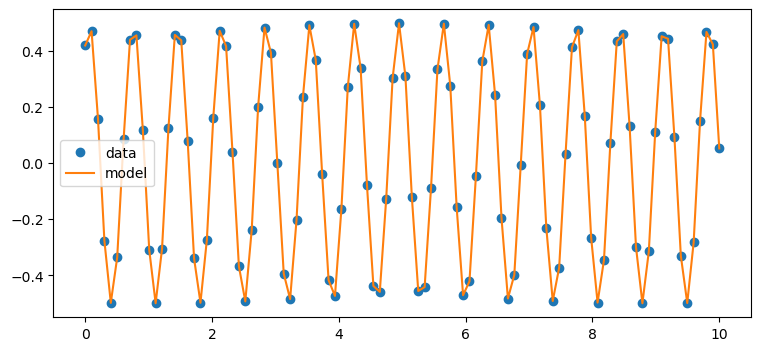

In [15]:
x_data = np.linspace(0,10,100)
y_data = 0.5*np.sin(x_data*9+1)

def model(params):
    y = 10**params[0]*np.sin(10**params[1]*x_data+params[2]) 
    return y

def loss(params):    
    diff = model(params) - y_data
    return np.sum(diff**2)

import scipy.optimize as opt
%time sol = opt.dual_annealing(loss, bounds=[[-1,1] for i in np.arange(2)] + [[0, np.pi]] )
print(sol.x)

fig = plt.figure(figsize=(9, 4))
plt.plot(x_data, y_data, 'o', label='data')
plt.plot(x_data, model(sol.x), label='model')
plt.legend()

### Parallel computing

In [6]:
from multiprocessing import Pool
import time
import math

In [7]:
X.shape

(202, 47)

In [14]:
k_max = 47

N = 100
t = bjd_daily - min(bjd_daily)
amp = np.logspace(-1, 1, N)
amp_pred = np.zeros(N)
w_array = np.zeros((N, k_max))
rms_array = np.zeros(N)
phase_array = np.zeros(N)
t_array = np.zeros(N)
initial_guess = np.ones(k_max+4)

def wmse(y1, y2, w):
    wmse = np.sum(w*(y1-y2)**2)/np.sum(w)
    return wmse

def model(params):
    y = np.sum(params[:k_max]*X[:,:k_max], axis=1) + params[k_max] + 10**params[k_max+1]*np.sin(10**params[k_max+3]*t + params[k_max+2]) 
    return y

if 0:
    def model(params):
        y = np.sum(params[:k_max]*X[:,:k_max], axis=1) + params[k_max] + 10**params[k_max+1]*np.sin(t + params[k_max+2]) 
        return y


def execute(i):
    y = Y + amp[i] *np.sin(1*t+0.3)  
    
    def loss(params):
        return wmse(model(params), y, 1/σrv_daily**2)
    
    sol = opt.dual_annealing(loss, bounds=[[-1,1.5] for i in np.arange(k_max+1)] + [[-1.1,1.1], [0, np.pi], [np.log10(1/1.5), np.log10(1*1.5)]],  maxiter=1000)
    
    fitted_params = sol.x

    w_array[i] = fitted_params[:k_max]
    amp_pred[i] = 10**fitted_params[k_max+1]
    phase_array[i] = fitted_params[k_max+2]
    t_array[i] = 10**fitted_params[k_max+3]
    rms_array[i] = loss(fitted_params)**0.5
    
    return w_array[i], amp[i], amp_pred[i], phase_array[i], t_array[i], rms_array[i]

if __name__ == "__main__":
    # first way, using multiprocessing
    start_time = time.perf_counter()
    
    with Pool(processes=os.cpu_count()) as pool:
        result = pool.map(execute, range(0,N)) 
    
    finish_time = time.perf_counter()
    print("Program finished in {} seconds - using multiprocessing".format(finish_time-start_time))
    print("---")

for i in range(len(result)):
    w_array[i], _, amp_pred[i], phase_array[i], t_array[i], rms_array[i] = result[i] 
    
print('amp\n', amp)
print('amp_pred\n', amp_pred)
print('t_array\n', t_array)
print('phase_array\n', phase_array)
print('rms_array\n', rms_array)

Program finished in 62.2945874389261 seconds - using multiprocessing
---
amp
 [ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.2745491

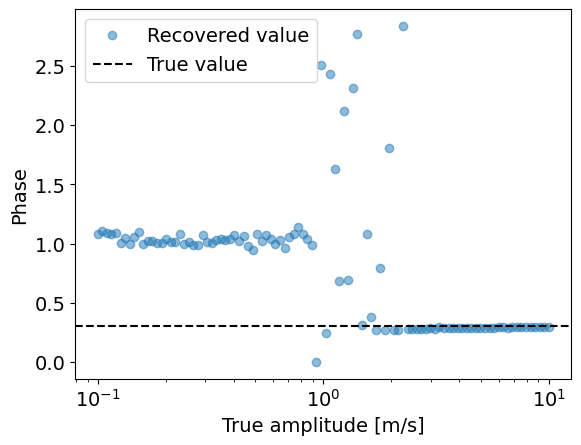

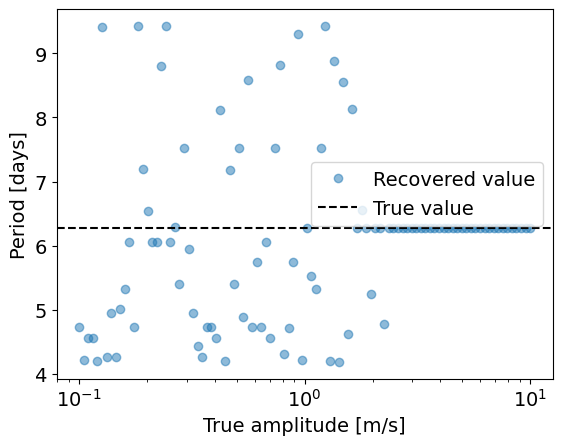

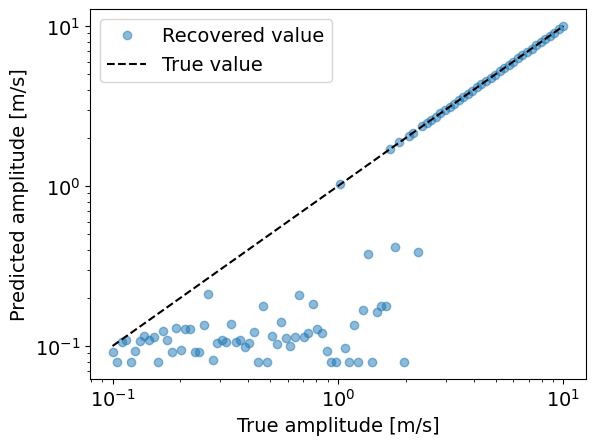

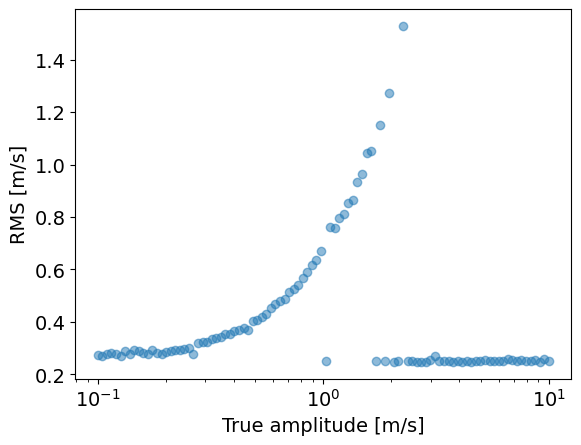

In [15]:
plt.rcParams['font.size'] = '14'

plt.plot(amp, phase_array, 'o', alpha=0.5, label='Recovered value')
plt.xscale('log')
# plt.xlim([0.009, 5])
plt.axhline(y = 0.3, color = 'k', linestyle = '--', label='True value')
plt.xlabel('True amplitude [m/s]')
plt.ylabel('Phase')
plt.legend()
plt.show()

plt.plot(amp, 2*np.pi/t_array, 'o', alpha=0.5, label='Recovered value')
plt.xscale('log')
# plt.xlim([0.009, 5])
plt.axhline(y = 2*np.pi, color = 'k', linestyle = '--', label='True value')
plt.xlabel('True amplitude [m/s]')
plt.ylabel('Period [days]')
plt.legend()
plt.show()

plt.plot(amp, amp_pred, 'o', alpha=0.5, label='Recovered value')
plt.plot(amp, amp, 'k--', label='True value')
plt.xlabel('True amplitude [m/s]')
plt.ylabel('Predicted amplitude [m/s]')
# plt.xlim([0.09, 5])
# plt.ylim([0.09, 5])
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(amp, rms_array, 'o', alpha=0.5)
plt.xlabel('True amplitude [m/s]')
plt.ylabel('RMS [m/s]')
plt.xscale('log')
plt.show()

In [ ]:
# injected parameters 
t_inj = 0.5
phase_inj = 2

N = 100
t = bjd_daily - min(bjd_daily)
amp = np.logspace(-1, 1, N)
amp_pred = np.zeros(N)
w_array = np.zeros((N, 47))
rms_array = np.zeros(N)
phase_array = np.zeros(N)
t_array = np.zeros(N)
initial_guess = np.ones(51)

def wmse(y1, y2, w):
    wmse = np.sum(w*(y1-y2)**2)/np.sum(w)
    return wmse

def model(params):
    y = np.sum(params[:47]*X, axis=1) + params[47] + 10**params[48]*np.sin(10**params[50]*t + params[49]) 
    return y

if 0:
    def model(params):
        y = np.sum(params[:47]*X, axis=1) + params[47] + 10**params[48]*np.sin(t + params[49]) 
        return y


def execute(i):
    y = Y + amp[i] *np.sin(t_inj*t+phase_inj)  
    
    def loss(params):
        return wmse(model(params), y, 1/σrv_daily**2)
    
    sol = opt.dual_annealing(loss, bounds=[[-1,1.5] for i in np.arange(48)] + [[-1.1,1.1], [0, np.pi], [np.log10(t_inj/1.5), np.log10(t_inj*1.5)]],  maxiter=50000)
    
    fitted_params = sol.x

    w_array[i] = fitted_params[:47]
    amp_pred[i] = 10**fitted_params[48]
    phase_array[i] = fitted_params[49]
    t_array[i] = 10**fitted_params[50]
    rms_array[i] = loss(fitted_params)**0.5
    
    return w_array[i], amp[i], amp_pred[i], phase_array[i], t_array[i], rms_array[i]

if __name__ == "__main__":
    # first way, using multiprocessing
    start_time = time.perf_counter()
    
    with Pool(processes=os.cpu_count()) as pool:
        result = pool.map(execute, range(0,N)) 
    
    finish_time = time.perf_counter()
    print("Program finished in {} seconds - using multiprocessing".format(finish_time-start_time))
    print("---")

for i in range(len(result)):
    w_array[i], _, amp_pred[i], phase_array[i], t_array[i], rms_array[i] = result[i] 
    
print('amp\n', amp)
print('amp_pred\n', amp_pred)
print('t_array\n', t_array)
print('phase_array\n', phase_array)
print('rms_array\n', rms_array)

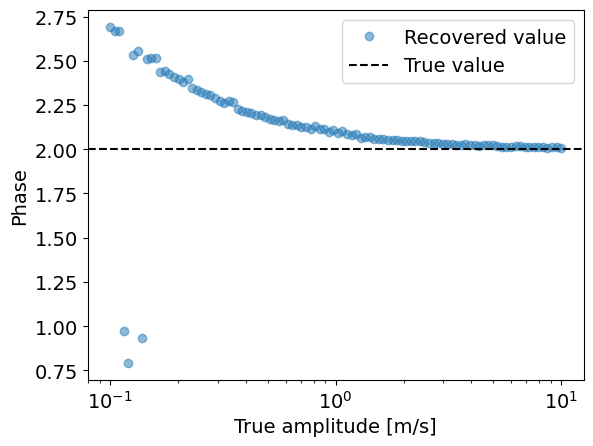

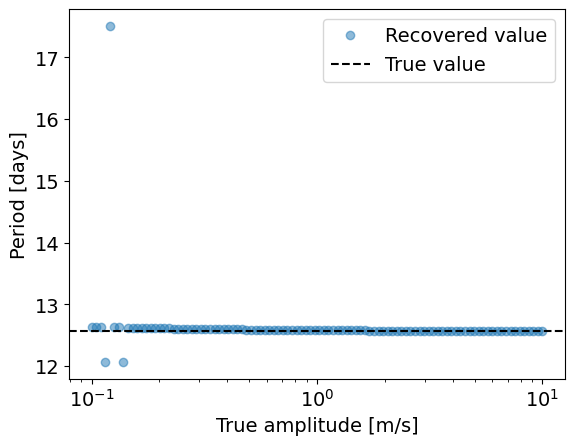

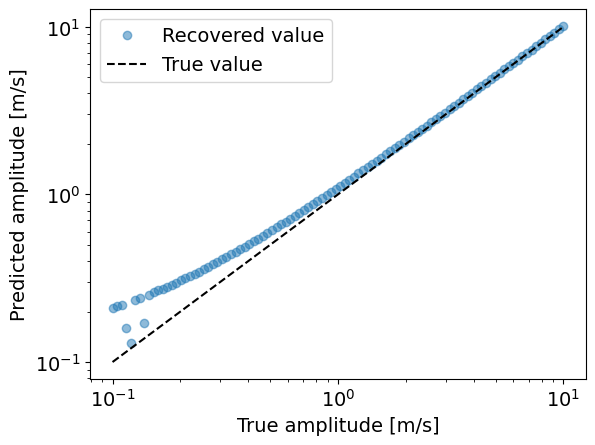

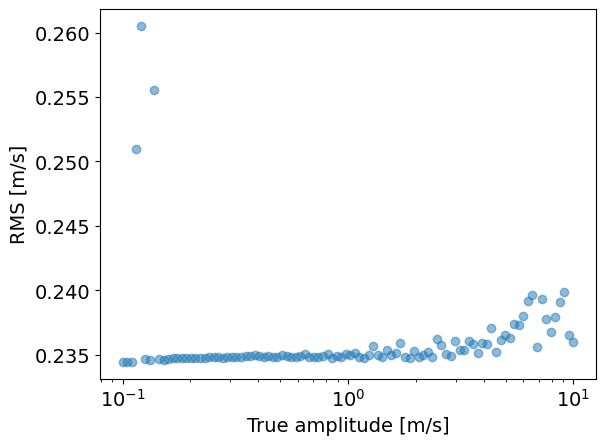

In [19]:
plt.rcParams['font.size'] = '14'

plt.plot(amp, phase_array, 'o', alpha=0.5, label='Recovered value')
plt.xscale('log')
# plt.xlim([0.009, 5])
plt.axhline(y = phase_inj, color = 'k', linestyle = '--', label='True value')
plt.xlabel('True amplitude [m/s]')
plt.ylabel('Phase')
plt.legend()
plt.show()

plt.plot(amp, 2*np.pi/t_array, 'o', alpha=0.5, label='Recovered value')
plt.xscale('log')
# plt.xlim([0.009, 5])
plt.axhline(y = 2*np.pi/t_inj, color = 'k', linestyle = '--', label='True value')
plt.xlabel('True amplitude [m/s]')
plt.ylabel('Period [days]')
plt.legend()
plt.show()

plt.plot(amp, amp_pred, 'o', alpha=0.5, label='Recovered value')
plt.plot(amp, amp, 'k--', label='True value')
plt.xlabel('True amplitude [m/s]')
plt.ylabel('Predicted amplitude [m/s]')
# plt.xlim([0.09, 5])
# plt.ylim([0.09, 5])
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(amp, rms_array, 'o', alpha=0.5)
plt.xlabel('True amplitude [m/s]')
plt.ylabel('RMS [m/s]')
plt.xscale('log')
plt.show()